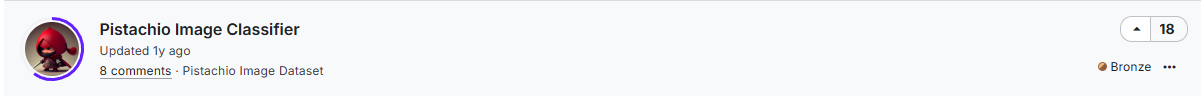

In [31]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import pathlib
import glob
import splitfolders

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, StratifiedKFold


import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [32]:
Dataset_dir = r"D:\code_study\ML_CODE\dataSets\Pistachio_Image_Dataset\Pistachio_Image_Dataset"
Dataset_dir = pathlib.Path(Dataset_dir)

Total_images = glob.glob("D:\code_study\ML_CODE\dataSets\Pistachio_Image_Dataset\Pistachio_Image_Dataset")

In [23]:
splitfolders.ratio(Dataset_dir, output='output', seed=101, ratio=(.7, .15, .15))

In [33]:
train_path = './output/train'
test_path = './output/test'
val_path = './output/val'

Total_TrainImages = glob.glob(train_path + '/*/*.jpg')
print("Total number of training images: ", len(Total_TrainImages))

Total_TestImages = glob.glob(test_path + '/*/*.jpg')
print("Total number of test images: ", len(Total_TestImages))

Total_ValImages = glob.glob(val_path + '/*/*.jpg')
print("Total number of validation images: ", len(Total_ValImages))


Total number of training images:  1503
Total number of test images:  324
Total number of validation images:  321


In [34]:
train_image_names = pd.Series(Total_TrainImages)
train_df = pd.DataFrame()
train_df['Filename'] = train_image_names.map(lambda x: x.split('\\')[-1])
train_df['ClassId'] = train_image_names.map(lambda x: x.split('\\')[-2])

train_df.head(10)

,Filename,ClassId
0,kirmizi (1).jpg,Kirmizi_Pistachio
1,kirmizi (10).jpg,Kirmizi_Pistachio
2,kirmizi (12).jpg,Kirmizi_Pistachio
3,kirmizi (13).jpg,Kirmizi_Pistachio
4,kirmizi (14).jpg,Kirmizi_Pistachio
5,kirmizi (15).jpg,Kirmizi_Pistachio
6,kirmizi (16).jpg,Kirmizi_Pistachio
7,kirmizi (17).jpg,Kirmizi_Pistachio
8,kirmizi (18).jpg,Kirmizi_Pistachio
9,kirmizi (19).jpg,Kirmizi_Pistachio


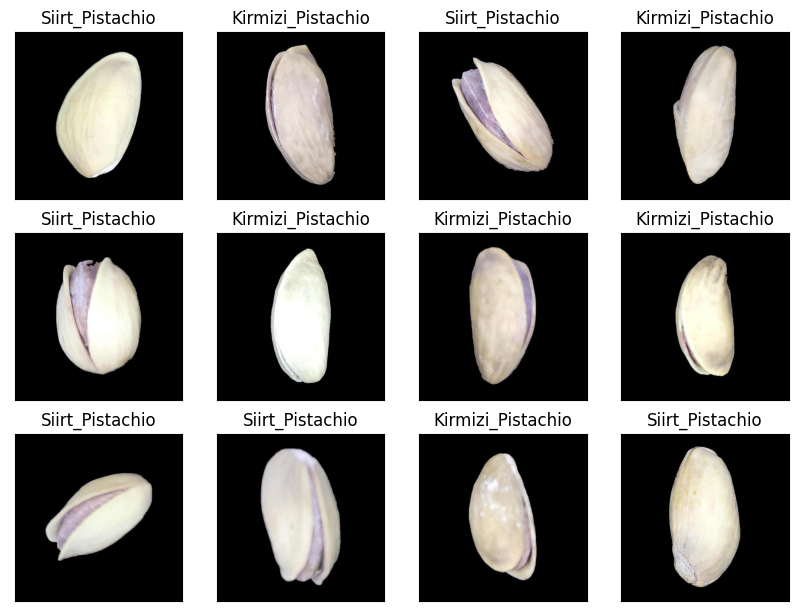

In [35]:
plot_df = train_df.sample(12).reset_index()
plt.figure(figsize=(10, 10))

for i in range(12):
    img_name = plot_df.loc[i, 'Filename']
    label = (plot_df.loc[i, 'ClassId'])

    plt.subplot(4, 4, i + 1)
    plt.imshow(plt.imread(os.path.join(train_path, label, img_name)))
    plt.title(label)
    plt.xticks([])
    plt.yticks([])

In [36]:
train_datagen = ImageDataGenerator(
    samplewise_center=True,
    zoom_range = 0.1,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1/255.,
)

test_datagen = ImageDataGenerator(rescale=1/255.)

batch_size = 32

img_size = 64

In [37]:
train_generator = train_datagen.flow_from_directory(
    directory=train_path, 
    batch_size=batch_size,
    class_mode='categorical',
    target_size=(img_size, img_size)
)

val_generator = test_datagen.flow_from_directory(
    directory=val_path,
    batch_size=batch_size,
    class_mode='categorical',
    target_size=(img_size, img_size)
)

test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    batch_size=batch_size,
    class_mode='categorical',
    target_size=(img_size, img_size)
)

Found 1503 images belonging to 2 classes.
Found 321 images belonging to 2 classes.
Found 324 images belonging to 2 classes.


In [38]:
data_train = image_dataset_from_directory(
    Dataset_dir,
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=0,
    color_mode='rgb',
    image_size=(img_size, img_size),
    batch_size=batch_size,
)

data_test = image_dataset_from_directory(
    Dataset_dir,
    validation_split=0.2,
    subset='validation',
    label_mode='categorical',
    seed=0,
    color_mode='rgb',
    image_size=(img_size, img_size),
    batch_size=batch_size,
)

Found 2148 files belonging to 2 classes.
Using 1719 files for training.
Found 2148 files belonging to 2 classes.
Using 429 files for validation.


In [30]:
# #use cnn model
# cnn = models.Sequential()

# cnn.add(layers.Conv2D(filters=2048, kernel_size=3, activation='relu', input_shape=(64,64,3)))
# cnn.add(layers.MaxPooling2D(pool_size=2, strides=2))

# cnn.add(layers.Conv2D(filters=2048, kernel_size=3, activation='relu'))
# cnn.add(layers.MaxPooling2D(pool_size=2, strides=2))

# cnn.add(layers.Conv2D(filters=2048, kernel_size=3, activation='relu'))
# cnn.add(layers.MaxPooling2D(pool_size=2, strides=2))

# cnn.add(layers.Dense(2048, activation='relu'))
# cnn.add(layers.MaxPool2D(pool_size=2, strides=2))

# cnn.add(layers.Dense(2048, activation='relu'))
# cnn.add(layers.MaxPool2D(pool_size=2, strides=2))

# cnn.add(layers.Flatten())

# cnn.add(layers.Dense(units=1, activation='sigmoid'))

# cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# cnn.fit(x = train_generator, validation_data=val_generator, epochs=100)

Epoch 1/100


KeyboardInterrupt: 

In [ ]:
print(cnn.summary)

In [ ]:
test_loss, test_acc = cnn.evaluate(data_test, steps=len(data_test), verbose=1)

In [41]:
#VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

base_model.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.4)(x)

predictions = layers.Dense(2, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(data_train,
                    epochs=50,
                    validation_data=data_test,
                    validation_steps=int(0.1 * len(data_test)),
                    verbose=1)


Epoch 1/50
54/54 [==============================] - 4s 65ms/step - loss: 14.9174 - accuracy: 0.5958 - val_loss: 0.5245 - val_accuracy: 0.7188
Epoch 2/50
54/54 [==============================] - 4s 63ms/step - loss: 0.4591 - accuracy: 0.7722 - val_loss: 0.4791 - val_accuracy: 0.8125
Epoch 3/50
54/54 [==============================] - 4s 63ms/step - loss: 0.3817 - accuracy: 0.8389 - val_loss: 0.3130 - val_accuracy: 0.8438
Epoch 4/50
54/54 [==============================] - 4s 64ms/step - loss: 0.3786 - accuracy: 0.8361 - val_loss: 0.2996 - val_accuracy: 0.8750
Epoch 5/50
54/54 [==============================] - 4s 63ms/step - loss: 0.3646 - accuracy: 0.8464 - val_loss: 0.4319 - val_accuracy: 0.8750
Epoch 6/50
54/54 [==============================] - 4s 63ms/step - loss: 0.3451 - accuracy: 0.8431 - val_loss: 0.2448 - val_accuracy: 0.9062
Epoch 7/50
54/54 [==============================] - 4s 62ms/step - loss: 0.3086 - accuracy: 0.8668 - val_loss: 0.1411 - val_accuracy: 1.0000
Epoch 8/50
5

In [42]:
print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [45]:
test_loss, test_acc = model.evaluate(data_test, steps=len(data_test), verbose=1)
print('Accuracy:%.3f' %(test_acc*100.0))


14/14 [==============================] - 1s 67ms/step - loss: 0.4224 - accuracy: 0.9021
Accuracy:90.210


In [75]:
#MLP for 16 Featured data
excel_path = r"D:\code_study\ML_CODE\dataSets\Pistachio_Image_Dataset\Pistachio_28_Features_Dataset\Pistachio_28_Features_Dataset.xls"
feature_data = pd.read_excel(excel_path)
feature_data

,Area,Perimeter,Major_Axis,Minor_Axis,Eccentricity,Eqdiasq,Solidity,Convex_Area,Extent,Aspect_Ratio,...,StdDev_RR,StdDev_RG,StdDev_RB,Skew_RR,Skew_RG,Skew_RB,Kurtosis_RR,Kurtosis_RG,Kurtosis_RB,Class
0,63391,1568.4050,390.3396,236.7461,0.7951,284.0984,0.8665,73160,0.6394,1.6488,...,17.7206,19.6024,21.1342,0.4581,0.6635,0.7591,2.9692,3.0576,2.9542,Kirmizi_Pistachio
1,68358,1942.1870,410.8594,234.7525,0.8207,295.0188,0.8765,77991,0.6772,1.7502,...,26.7061,27.2112,25.1035,-0.3847,-0.2713,-0.2927,1.9807,2.1006,2.2152,Kirmizi_Pistachio
2,73589,1246.5380,452.3630,220.5547,0.8731,306.0987,0.9172,80234,0.7127,2.0510,...,19.0129,20.0703,20.7006,-0.6014,-0.4500,0.2998,3.5420,3.6856,4.1012,Kirmizi_Pistachio
3,71106,1445.2610,429.5291,216.0765,0.8643,300.8903,0.9589,74153,0.7028,1.9879,...,18.1773,18.7152,29.7883,-0.6943,-0.6278,-0.7798,2.8776,2.8748,2.8953,Kirmizi_Pistachio
4,80087,1251.5240,469.3783,220.9344,0.8823,319.3273,0.9657,82929,0.7459,2.1245,...,23.4298,24.0878,23.1157,-0.9287,-0.8134,-0.4970,2.9915,2.8813,2.7362,Kirmizi_Pistachio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,85983,1157.1160,444.3447,248.8627,0.8284,330.8730,0.9823,87536,0.6799,1.7855,...,20.8474,20.8118,21.1175,-0.6994,-0.7071,-0.6963,2.8853,2.6599,2.6317,Siirt_Pistachio
2144,85691,2327.3459,439.8794,278.9297,0.7732,330.3107,0.8886,96439,0.6590,1.5770,...,21.2621,22.5004,21.5821,-0.5567,-0.4968,-0.6597,2.3022,2.2664,2.5161,Siirt_Pistachio
2145,101136,1255.6190,475.2161,271.3299,0.8210,358.8459,0.9888,102286,0.7584,1.7514,...,21.1262,20.0279,17.4401,-0.9072,-0.8790,-0.4470,3.3112,3.4306,3.0697,Siirt_Pistachio
2146,97409,1195.2150,452.1823,274.5764,0.7945,352.1718,0.9902,98376,0.7635,1.6468,...,19.3274,19.1782,19.8930,-0.9473,-0.8404,-0.3153,3.4237,2.9606,3.0033,Siirt_Pistachio


In [76]:
feature_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2148 entries, 0 to 2147
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Area           2148 non-null   int64  
 1   Perimeter      2148 non-null   float64
 2   Major_Axis     2148 non-null   float64
 3   Minor_Axis     2148 non-null   float64
 4   Eccentricity   2148 non-null   float64
 5   Eqdiasq        2148 non-null   float64
 6   Solidity       2148 non-null   float64
 7   Convex_Area    2148 non-null   int64  
 8   Extent         2148 non-null   float64
 9   Aspect_Ratio   2148 non-null   float64
 10  Roundness      2148 non-null   float64
 11  Compactness    2148 non-null   float64
 12  Shapefactor_1  2148 non-null   float64
 13  Shapefactor_2  2148 non-null   float64
 14  Shapefactor_3  2148 non-null   float64
 15  Shapefactor_4  2148 non-null   float64
 16  Mean_RR        2148 non-null   float64
 17  Mean_RG        2148 non-null   float64
 18  Mean_RB 

In [77]:
feature_data.describe()

,Area,Perimeter,Major_Axis,Minor_Axis,Eccentricity,Eqdiasq,Solidity,Convex_Area,Extent,Aspect_Ratio,...,Mean_RB,StdDev_RR,StdDev_RG,StdDev_RB,Skew_RR,Skew_RG,Skew_RB,Kurtosis_RR,Kurtosis_RG,Kurtosis_RB
count,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,...,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000
mean,79950.655493,1425.971751,446.248968,238.311842,0.840219,317.919173,0.940093,85015.839851,0.716067,1.898154,...,191.995311,21.380084,22.591454,22.427056,-0.735243,-0.615580,-0.367142,3.054000,2.903015,2.940572
std,13121.737799,375.565503,32.445304,30.310695,0.048759,26.908600,0.050452,13154.919327,0.052532,0.240100,...,13.030505,3.127813,3.622222,3.926325,0.384584,0.389219,0.426964,0.733993,0.651383,0.750171
min,29808.000000,858.363000,320.344500,133.509600,0.504900,194.814600,0.588000,37935.000000,0.427200,1.158500,...,146.787600,10.611100,11.985400,11.197100,-1.931600,-1.658200,-2.348600,1.662400,1.665500,1.522500
25%,71936.750000,1170.996250,426.508750,217.875825,0.817500,302.642850,0.919850,76467.000000,0.687000,1.736375,...,182.930675,19.253550,20.036675,19.722425,-0.990900,-0.875975,-0.645800,2.509700,2.437400,2.449425
50%,79905.500000,1262.785500,448.574750,236.416350,0.849650,318.965300,0.954150,85075.500000,0.726500,1.896250,...,192.036350,21.425100,22.523250,22.276900,-0.756600,-0.653050,-0.424550,2.941750,2.807050,2.783350
75%,89030.500000,1607.906250,468.509400,257.760150,0.875200,336.685525,0.976925,93893.500000,0.753600,2.067025,...,201.097725,23.695900,25.241900,25.140125,-0.502500,-0.405000,-0.158400,3.446500,3.247400,3.224650
max,124008.000000,2755.049100,541.966100,383.046100,0.946000,397.356100,0.995100,132478.000000,0.820400,3.085800,...,235.000700,30.838300,33.614600,42.756600,1.865400,2.257600,1.852100,8.890600,10.453900,11.533900


In [100]:
feature_data['Class'].value_counts()

Kirmizi_Pistachio    1232
Siirt_Pistachio       916
Name: Class, dtype: int64

In [102]:
Kirmizi_Pistachio = feature_data[feature_data['Class'] == 'Kirmizi_Pistachio'].shape[0]
Siit_Pistachio = feature_data[feature_data['Class'] == 'Siirt_Pistachio'].shape[0]
Siit_Pistachio

916

([<matplotlib.patches.Wedge at 0x1486a218d48>,
 [Text(-1.0532743721094677, 0.3171956762905301, 'Kirmizi_Pistachio'),
  Text(1.3405309812509496, -0.4037037135157002, 'Siit_Pistachio')],
 [Text(-0.5745132938778914, 0.17301582343119823, '57.4%'),
  Text(0.8617699165184675, -0.2595238158315215, '42.6%')])

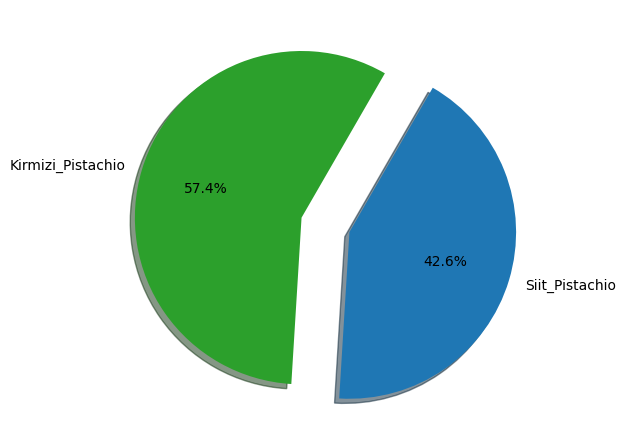

In [103]:
#分析预测值分布
lt_font = {'family': 'serif', 'size':18}

plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=1, bottom=1, right=2.5, top=5, wspace=0.3, hspace=None)
plt.subplot(1, 3, 1)
plt.pie(x = [Kirmizi_Pistachio, Siit_Pistachio], labels=['Kirmizi_Pistachio', 'Siit_Pistachio'], colors=['tab:green', 'tab:blue'],
        explode=[0, 0.3], shadow=True, autopct='%.1f%%', startangle=60)


In [104]:
feature_X = feature_data.drop(['Class'], axis=1)
feature_y = feature_data['Class']
feature_y

0       Kirmizi_Pistachio
1       Kirmizi_Pistachio
2       Kirmizi_Pistachio
3       Kirmizi_Pistachio
4       Kirmizi_Pistachio
              ...        
2143      Siirt_Pistachio
2144      Siirt_Pistachio
2145      Siirt_Pistachio
2146      Siirt_Pistachio
2147      Siirt_Pistachio
Name: Class, Length: 2148, dtype: object

In [106]:
X_train, X_test, y_train, y_test = train_test_split(feature_X, feature_y, test_size=0.2, random_state=42)


In [107]:
print("X_train shape:", X_train.shape)
print('y_train shape:', y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1718, 28)
y_train shape: (1718,)
X_test shape: (430, 28)
y_test shape: (430,)


In [108]:
#feature scalling
sc = StandardScaler()
scaler = sc.fit(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [109]:
#MLP model
mlp_clf = MLPClassifier(hidden_layer_sizes=(20, 25, 10), max_iter=30, activation='relu', solver='adam')
mlp_clf.fit(X_train_scaler, y_train)

c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(hidden_layer_sizes=(20, 25, 10), max_iter=30)

In [110]:
y_pred = mlp_clf.predict(X_test_scaler)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))


Accuracy: 0.93


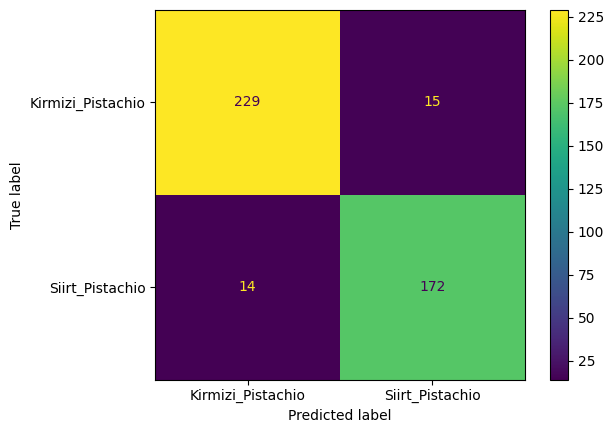

In [111]:
predictions = mlp_clf.predict(X_test_scaler)
cm = confusion_matrix(y_test, predictions, labels=mlp_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_clf.classes_)
disp.plot()

In [112]:
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

Kirmizi_Pistachio       0.94      0.94      0.94       244
  Siirt_Pistachio       0.92      0.92      0.92       186

         accuracy                           0.93       430
        macro avg       0.93      0.93      0.93       430
     weighted avg       0.93      0.93      0.93       430



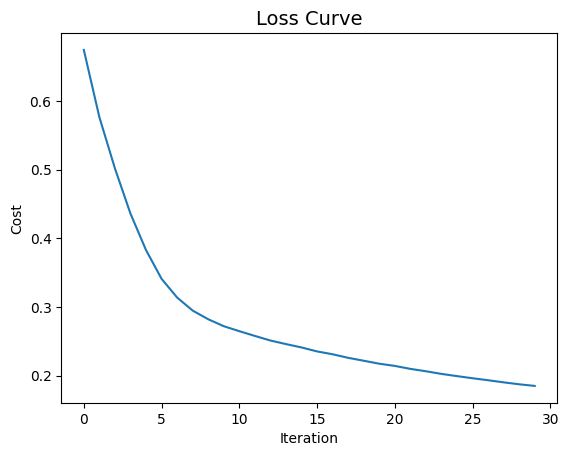

In [113]:
plt.plot(mlp_clf.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [114]:
#超参数修改
param_grid = {
    'hidden_layer_sizes': [(150, 100, 50), (128, 64, 40), (100, 50, 30), (512, 254, 50)],
    'max_iter' : [50, 100, 150, 200],
    'activation': ['relu', 'tanh'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

my_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
random_search = RandomizedSearchCV(estimator=mlp_clf, param_distributions=param_grid, cv=3, n_jobs=1,
                                   n_iter=20, scoring='accuracy', verbose=5, random_state=1)
random_search.fit(X_train_scaler, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(150, 100, 50), learning_rate=constant, max_iter=50, solver=sgd;, score=0.904 total time=   0.6s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(150, 100, 50), learning_rate=constant, max_iter=50, solver=sgd;, score=0.880 total time=   0.6s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(150, 100, 50), learning_rate=constant, max_iter=50, solver=sgd;, score=0.893 total time=   0.6s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 30), learning_rate=adaptive, max_iter=100, solver=sgd;, score=0.899 total time=   0.9s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 30), learning_rate=adaptive, max_iter=100, solver=sgd;, score=0.895 total time=   0.9s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50, 30), learning_rate=adaptive, max_iter=100, solver=sgd;, score=0.885 total time=   0.9s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(512, 254, 50), learning_rate=adaptive, max_iter=100, solver=sgd;, score=0.906 total time=   3.0s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(512, 254, 50), learning_rate=adaptive, max_iter=100, solver=sgd;, score=0.899 total time=   3.0s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(512, 254, 50), learning_rate=adaptive, max_iter=100, solver=sgd;, score=0.899 total time=   4.8s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(512, 254, 50), learning_rate=adaptive, max_iter=200, solver=sgd;, score=0.920 total time=  14.1s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(512, 254, 50), learning_rate=adaptive, max_iter=200, solver=sgd;, score=0.904 total time=  13.8s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(512, 254, 50), learning_rate=adaptive, max_iter=200, solver=sgd;, score=0.907 total time=  13.8s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/3] END activation=relu, alpha=0.05, hidden_layer_sizes=(512, 254, 50), learning_rate=adaptive, max_iter=50, solver=adam;, score=0.927 total time=   3.9s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/3] END activation=relu, alpha=0.05, hidden_layer_sizes=(512, 254, 50), learning_rate=adaptive, max_iter=50, solver=adam;, score=0.925 total time=   3.9s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/3] END activation=relu, alpha=0.05, hidden_layer_sizes=(512, 254, 50), learning_rate=adaptive, max_iter=50, solver=adam;, score=0.932 total time=   3.9s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64, 40), learning_rate=adaptive, max_iter=100, solver=adam;, score=0.925 total time=   2.3s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64, 40), learning_rate=adaptive, max_iter=100, solver=adam;, score=0.918 total time=   2.4s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(128, 64, 40), learning_rate=adaptive, max_iter=100, solver=adam;, score=0.935 total time=   2.3s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/3] END activation=relu, alpha=0.05, hidden_layer_sizes=(150, 100, 50), learning_rate=adaptive, max_iter=100, solver=adam;, score=0.923 total time=   2.6s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/3] END activation=relu, alpha=0.05, hidden_layer_sizes=(150, 100, 50), learning_rate=adaptive, max_iter=100, solver=adam;, score=0.914 total time=   2.6s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/3] END activation=relu, alpha=0.05, hidden_layer_sizes=(150, 100, 50), learning_rate=adaptive, max_iter=100, solver=adam;, score=0.923 total time=   2.7s
[CV 1/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64, 40), learning_rate=adaptive, max_iter=200, solver=adam;, score=0.927 total time=   2.1s
[CV 2/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64, 40), learning_rate=adaptive, max_iter=200, solver=adam;, score=0.913 total time=   2.2s
[CV 3/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64, 40), learning_rate=adaptive, max_iter=200, solver=adam;, score=0.918 total time=   2.2s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(150, 100, 50), learning_rate=constant, max_iter=100, solver=sgd;, score=0.904 total time=   2.6s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(150, 100, 50), learning_rate=constant, max_iter=100, solver=sgd;, score=0.890 total time=   3.0s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(150, 100, 50), learning_rate=constant, max_iter=100, solver=sgd;, score=0.897 total time=   2.6s
[CV 1/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(512, 254, 50), learning_rate=adaptive, max_iter=200, solver=adam;, score=0.925 total time=   5.0s
[CV 2/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(512, 254, 50), learning_rate=adaptive, max_iter=200, solver=adam;, score=0.930 total time=   5.0s
[CV 3/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(512, 254, 50), learning_rate=adaptive, max_iter=200, solver=adam;, score=0.921 total time=   5.1s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(512, 254, 50), learning_rate=constant, max_iter=100, solver=sgd;, score=0.909 total time=   7.1s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(512, 254, 50), learning_rate=constant, max_iter=100, solver=sgd;, score=0.895 total time=   7.1s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(512, 254, 50), learning_rate=constant, max_iter=100, solver=sgd;, score=0.904 total time=   7.1s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(150, 100, 50), learning_rate=constant, max_iter=150, solver=sgd;, score=0.906 total time=   3.8s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(150, 100, 50), learning_rate=constant, max_iter=150, solver=sgd;, score=0.902 total time=   3.8s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(150, 100, 50), learning_rate=constant, max_iter=150, solver=sgd;, score=0.897 total time=   3.7s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(150, 100, 50), learning_rate=constant, max_iter=150, solver=sgd;, score=0.911 total time=   3.9s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(150, 100, 50), learning_rate=constant, max_iter=150, solver=sgd;, score=0.894 total time=   4.0s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(150, 100, 50), learning_rate=constant, max_iter=150, solver=sgd;, score=0.911 total time=   4.0s
[CV 1/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(512, 254, 50), learning_rate=constant, max_iter=200, solver=adam;, score=0.930 total time=   4.9s
[CV 2/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(512, 254, 50), learning_rate=constant, max_iter=200, solver=adam;, score=0.934 total time=   5.4s
[CV 3/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(512, 254, 50), learning_rate=constant, max_iter=200, solver=adam;, score=0.927 total time=   5.1s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(150, 100, 50), learning_rate=constant, max_iter=200, solver=sgd;, score=0.906 total time=   5.0s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(150, 100, 50), learning_rate=constant, max_iter=200, solver=sgd;, score=0.894 total time=   5.0s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/3] END activation=relu, alpha=0.0001, hidden_layer_sizes=(150, 100, 50), learning_rate=constant, max_iter=200, solver=sgd;, score=0.907 total time=   5.0s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/3] END activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50, 30), learning_rate=constant, max_iter=50, solver=adam;, score=0.923 total time=   0.8s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/3] END activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50, 30), learning_rate=constant, max_iter=50, solver=adam;, score=0.911 total time=   0.8s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/3] END activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50, 30), learning_rate=constant, max_iter=50, solver=adam;, score=0.937 total time=   0.8s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/3] END activation=tanh, alpha=0.05, hidden_layer_sizes=(150, 100, 50), learning_rate=constant, max_iter=50, solver=sgd;, score=0.897 total time=   1.3s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/3] END activation=tanh, alpha=0.05, hidden_layer_sizes=(150, 100, 50), learning_rate=constant, max_iter=50, solver=sgd;, score=0.897 total time=   1.3s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/3] END activation=tanh, alpha=0.05, hidden_layer_sizes=(150, 100, 50), learning_rate=constant, max_iter=50, solver=sgd;, score=0.890 total time=   1.3s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64, 40), learning_rate=adaptive, max_iter=100, solver=sgd;, score=0.894 total time=   2.0s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64, 40), learning_rate=adaptive, max_iter=100, solver=sgd;, score=0.894 total time=   2.3s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/3] END activation=relu, alpha=0.001, hidden_layer_sizes=(128, 64, 40), learning_rate=adaptive, max_iter=100, solver=sgd;, score=0.881 total time=   1.9s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/3] END activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50, 30), learning_rate=constant, max_iter=100, solver=adam;, score=0.930 total time=   1.7s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/3] END activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50, 30), learning_rate=constant, max_iter=100, solver=adam;, score=0.921 total time=   1.7s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/3] END activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50, 30), learning_rate=constant, max_iter=100, solver=adam;, score=0.920 total time=   1.8s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 30), learning_rate=constant, max_iter=200, solver=sgd;, score=0.909 total time=   3.6s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 30), learning_rate=constant, max_iter=200, solver=sgd;, score=0.902 total time=   3.6s


c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/3] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 30), learning_rate=constant, max_iter=200, solver=sgd;, score=0.909 total time=   3.6s


RandomizedSearchCV(cv=3,
                   estimator=MLPClassifier(hidden_layer_sizes=(20, 25, 10),
                                           max_iter=30),
                   n_iter=20, n_jobs=1,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'alpha': [0.0001, 0.001, 0.05],
                                        'hidden_layer_sizes': [(150, 100, 50),
                                                               (128, 64, 40),
                                                               (100, 50, 30),
                                                               (512, 254, 50)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'max_iter': [50, 100, 150, 200],
                                        'solver': ['sgd', 'adam']},
                   random_state=1, scoring='accuracy', verbos

In [121]:
print("The best parameters are: %s with a score of %0.3f"
      %(random_search.best_params_, random_search.best_score_))

The best parameters are: {'solver': 'adam', 'max_iter': 200, 'learning_rate': 'constant', 'hidden_layer_sizes': (512, 254, 50), 'alpha': 0.001, 'activation': 'relu'} with a score of 0.930


In [122]:
random_search_results = pd.concat([pd.DataFrame(random_search.cv_results_['params']),
                                   pd.DataFrame(random_search.cv_results_['mean_test_score'], columns=['Accuracy'])], axis=1)

random_search_results.sort_values(by='Accuracy', ascending=False)

,solver,max_iter,learning_rate,hidden_layer_sizes,alpha,activation,Accuracy
13,adam,200,constant,"(512, 254, 50)",0.0010,relu,0.930149
4,adam,50,adaptive,"(512, 254, 50)",0.0500,relu,0.927825
5,adam,100,adaptive,"(128, 64, 40)",0.0010,tanh,0.926082
9,adam,200,adaptive,"(512, 254, 50)",0.0010,relu,0.925492
15,adam,50,constant,"(100, 50, 30)",0.0500,relu,0.923756
18,adam,100,constant,"(100, 50, 30)",0.0500,relu,0.923746
6,adam,100,adaptive,"(150, 100, 50)",0.0500,relu,0.920258
7,adam,200,adaptive,"(128, 64, 40)",0.0010,relu,0.919091
3,sgd,200,adaptive,"(512, 254, 50)",0.0001,relu,0.910359
19,sgd,200,constant,"(100, 50, 30)",0.0010,tanh,0.906870


In [123]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(128, 64, 40),
                        max_iter=100,
                        activation='tanh',
                        solver='adam',
                        learning_rate='adaptive',
                        alpha=0.001)
mlp_clf.fit(X_train_scaler, y_train)

c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(128, 64, 40),
              learning_rate='adaptive', max_iter=100)

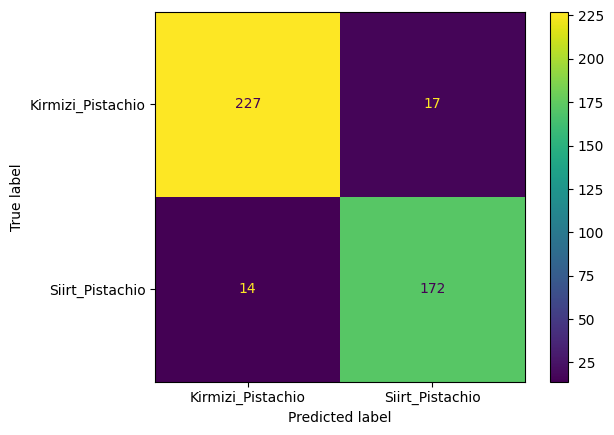

In [124]:
predictions = mlp_clf.predict(X_test_scaler)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_clf.classes_)
disp.plot()

In [125]:
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

Kirmizi_Pistachio       0.93      0.94      0.94       244
  Siirt_Pistachio       0.92      0.91      0.92       186

         accuracy                           0.93       430
        macro avg       0.93      0.93      0.93       430
     weighted avg       0.93      0.93      0.93       430



In [126]:
y_pred = mlp_clf.predict(X_test_scaler)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))

Accuracy: 0.93
